In [1]:
import math
import pandas as pd
import tensorflow as tf
# import keras_tuner.tuners as kt
import matplotlib.pyplot as plt
import keras
from tensorflow.keras import Model
from tensorflow.keras import Sequential
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import MeanSquaredLogarithmicError
from sklearn.metrics import accuracy_score, f1_score
import numpy as np
import pickle
np.random.seed(0)
from tensorflow.keras import Input
from tensorflow.keras.layers import Conv1D, Conv2D, LeakyReLU, MaxPool1D, AveragePooling1D, UpSampling1D, Flatten, Dense, Reshape, BatchNormalization
# https://towardsdatascience.com/improve-your-model-performance-with-auto-encoders-d4ee543b4154
from tensorflow.keras import initializers
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
from scipy.stats import multivariate_normal
from keras.optimizers import Adam, SGD, Adadelta
from kmeans_gmm_eval_fns import gmm_model_get_prediction_ae, gmm_model_get_prediction_pca
import objects


In [2]:
x_train_scaled = pd.read_csv('../data/260_sample_train_scaled.csv').set_index("Patient_ID")
x_train_scaled

AADAC     APOA1     APOA4      APOB     APOC3      AQP9  \
Patient_ID                                                                 
55_control    0.702813  0.799052  0.719665  0.729547  0.794953  0.256451   
168_CD_plain  0.751408  0.603707  0.622768  0.627712  0.606860  0.520576   
72_control    0.786508  0.755331  0.739605  0.756170  0.819875  0.391132   
120_control   0.707491  0.662993  0.648072  0.764621  0.654276  0.633929   
258_CD_plain  0.701039  0.662511  0.707208  0.834562  0.670160  0.410612   
...                ...       ...       ...       ...       ...       ...   
15_CD_plain   0.382762  0.384030  0.377332  0.360165  0.300915  0.340090   
182_CD_plain  0.679910  0.584723  0.722426  0.643867  0.740014  0.650358   
164_CD_plain  0.754656  0.556562  0.694062  0.748334  0.535534  0.133869   
53_CD_plain   0.591140  0.585802  0.750282  0.753309  0.603372  0.469634   
97_CD_plain   0.817125  0.782223  0.854442  0.867360  0.793421  0.726438   

                    C6   CEACAM7    CHI3L1     ABCC2  ...     HDLBP     PIAS4  \
Patient_ID                                            ...                       
55_control    1.000000  0.363133  0.374212  0.611161  ...  0.308725  0.235825   
168_CD_plain  0.311962  0.251356  0.553554  0.441131  ...  0.000000  0.000000   
72_control    0.648401  0.134017  0.200420  0.679453  ...  0.491401  0.279122   
120_control   0.579519  0.248934  0.759250  0.755407  ...  0.604918  0.598850   
258_CD_plain  0.370517  0.244987  0.445387  0.798000  ...  0.470835  0.670696   
...                ...       ...       ...       ...  ...       ...       ...   
15_CD_plain   0.077348  0.890965  0.261140  0.205779  ...  0.669319  0.770253   
182_CD_plain  0.468650  0.295686  0.649939  0.609862  ...  0.747236  0.742399   
164_CD_plain  0.319071  0.154562  0.440487  0.824013  ...  0.422981  0.769213   
53_CD_plain   0.213239  0.348800  0.485094  0.722492  ...  0.618164  0.707833   
97_CD_plain   0.246396  0.228774  0.611752  0.699944  ...  0.696152  0.625429   

                 ADH1B  LOC100507531    FAM83A      NXF4    RNF125      DARS  \
Patient_ID                                                                     
55_control    0.566757      0.982782  0.707526  1.000000  0.410887  0.671068   
168_CD_plain  0.861588      0.000000  0.640911  0.020238  0.220356  0.632252   
72_control    0.555258      0.000000  0.392175  0.000000  0.116289  0.000000   
120_control   0.621841      0.000000  0.519941  0.000000  0.342185  0.416527   
258_CD_plain  0.555250      0.000000  0.390923  0.000000  0.498504  0.449224   
...                ...           ...       ...       ...       ...       ...   
15_CD_plain   0.702931      0.000000  0.451846  0.000000  0.319644  0.549587   
182_CD_plain  0.730485      0.000000  0.680460  0.000000  0.280413  0.529434   
164_CD_plain  0.625325      0.000000  0.374319  0.000000  0.396084  0.590976   
53_CD_plain   0.842618      0.000000  0.441203  0.000000  0.355054  0.430549   
97_CD_plain   0.497239      0.000000  0.418343  0.000000  0.346990  0.629297   

                 DNAI1    MBTPS1  
Patient_ID                        
55_control    1.000000  0.438527  
168_CD_plain  0.000000  0.488578  
72_control    0.260194  0.531400  
120_control   0.000000  0.545708  
258_CD_plain  0.000000  0.689242  
...                ...       ...  
15_CD_plain   0.000000  0.935108  
182_CD_plain  0.000000  0.606330  
164_CD_plain  0.238307  0.753111  
53_CD_plain   0.000000  0.706947  
97_CD_plain   0.000000  0.634364  

[182 rows x 220 columns]

In [3]:
x_test_scaled = pd.read_csv('../data/260_sample_test_scaled.csv').set_index("Patient_ID")
x_test_scaled

AADAC     APOA1     APOA4      APOB     APOC3      AQP9  \
Patient_ID                                                                      
253_CD_plain       0.869185  0.841880  0.930171  0.886737  0.835678  0.297964   
105_CD_plain       0.853562  0.933532  0.942213  0.794578  0.890482  0.206529   
2_CD_plain         0.165531  0.141475  0.263684  0.198091  0.160503  0.888878   
184_CD_plain       0.717121  0.660314  0.769417  0.752737  0.694874  0.514735   
312_CD_plain       0.730072  0.722909  0.713076  0.743545  0.679258  0.308459   
...                     ...       ...       ...       ...       ...       ...   
107_CD_plain       0.736123  0.658232  0.772323  0.685637  0.658755  0.250970   
279_CD_plain       0.220614  0.202090  0.182810  0.113245  0.105744  0.699851   
179_CD_plain       0.724476  0.726774  0.766943  0.776284  0.690339  0.380637   
70_CD_deep_ulcer   0.488321  0.495439  0.574906  0.491337  0.540073  0.525943   
256_CD_deep_ulcer  0.609459  0.598912  0.682050  0.765806  0.648350  0.450384   

                         C6   CEACAM7    CHI3L1     ABCC2  ...     HDLBP  \
Patient_ID                                                 ...             
253_CD_plain       0.668498  0.266670  0.278122  0.933520  ...  0.775985   
105_CD_plain       0.298987  0.350745  0.495663  0.849038  ...  0.582213   
2_CD_plain         0.000000  0.134461  0.989132  0.202203  ...  0.907365   
184_CD_plain       0.692365  0.271127  0.650742  0.694599  ...  0.648501   
312_CD_plain       0.399235  0.129019  0.597529  0.720390  ...  0.493294   
...                     ...       ...       ...       ...  ...       ...   
107_CD_plain       0.247307  0.422075  0.555944  0.603675  ...  0.550182   
279_CD_plain       0.000000  0.908485  0.688912  0.178259  ...  0.819116   
179_CD_plain       0.440449  0.318944  0.558600  0.738787  ...  0.417027   
70_CD_deep_ulcer   0.397648  0.414520  0.709700  0.389618  ...  0.518145   
256_CD_deep_ulcer  0.000000  0.377102  0.444380  0.667302  ...  0.710513   

                      PIAS4     ADH1B  LOC100507531    FAM83A  NXF4    RNF125  \
Patient_ID                                                                      
253_CD_plain       0.973492  0.472825           0.0  0.269797   0.0  0.539781   
105_CD_plain       0.531660  0.540145           0.0  0.322049   0.0  0.303573   
2_CD_plain         0.736128 -0.336653           0.0 -0.069528   0.0  0.176989   
184_CD_plain       0.789699  0.836996           0.0  0.285660   0.0  0.320280   
312_CD_plain       0.566990  0.807264           0.0  0.471971   0.0  0.462733   
...                     ...       ...           ...       ...   ...       ...   
107_CD_plain       0.719685  0.701615           0.0  0.225656   0.0  0.295914   
279_CD_plain       0.689739  0.213157           0.0  0.969447   0.0  0.134090   
179_CD_plain       0.734039  0.683655           0.0  0.369566   0.0  0.405814   
70_CD_deep_ulcer   0.592796  0.889984           0.0  0.437243   0.0  0.216913   
256_CD_deep_ulcer  0.667492  0.601592           0.0  0.653043   0.0  0.409098   

                       DARS     DNAI1    MBTPS1  
Patient_ID                                       
253_CD_plain       0.290165  0.000000  0.722611  
105_CD_plain       0.133159  0.000000  0.537012  
2_CD_plain         0.766373  0.000000  1.094845  
184_CD_plain       0.488913  0.000000  0.674738  
312_CD_plain       0.508932  0.000000  0.693707  
...                     ...       ...       ...  
107_CD_plain       0.701896  0.000000  0.709542  
279_CD_plain       0.710444  0.000000  0.846294  
179_CD_plain       0.575430  0.000000  0.653918  
70_CD_deep_ulcer   0.514257  0.000000  0.621144  
256_CD_deep_ulcer  0.449809  0.152556  0.599646  

[78 rows x 220 columns]

In [4]:
patient_ids_train = np.array(x_train_scaled.index)
patient_ids_test = np.array(x_test_scaled.index)
patient_ids_train

array(['55_control', '168_CD_plain', '72_control', '120_control',
       '258_CD_plain', '254_CD_deep_ulcer', '9_CD_plain', '111_CD_plain',
       '57_CD_plain', '216_CD_deep_ulcer', '263_CD_deep_ulcer',
       '95_CD_deep_ulcer', '31_control', '172_CD_plain', '310_CD_plain',
       '68_CD_plain', '65_control', '285_CD_plain', '201_CD_plain',
       '223_CD_deep_ulcer', '320_CD_plain', '8_CD_plain',
       '99_CD_deep_ulcer', '90_control', '296_CD_deep_ulcer',
       '219_CD_deep_ulcer', '138_CD_deep_ulcer', '38_control',
       '113_CD_plain', '76_control', '146_CD_deep_ulcer',
       '147_CD_deep_ulcer', '186_CD_plain', '158_CD_plain',
       '299_CD_plain', '178_CD_plain', '189_CD_plain', '266_CD_plain',
       '231_CD_deep_ulcer', '198_CD_plain', '6_CD_deep_ulcer',
       '30_CD_plain', '265_CD_plain', '181_CD_deep_ulcer', '16_CD_plain',
       '264_CD_deep_ulcer', '209_CD_plain', '83_control', '214_CD_plain',
       '193_CD_deep_ulcer', '104_CD_plain', '66_CD_plain', '188_CD_plain

In [5]:
def classify(x):
    if "_control" in x: # control
        return 0
    elif "CD_plain" in x: # Crohn's Disease no deep ulcer
#         print(x)
        return 1
    elif "CD_deep_ulcer" in x: # Crohn's Disease deep ulcer
#         print(x)
        return 2
    else:
        return 3 # Ulcerative Collitis

vec = np.vectorize(classify)

disease_labels_train = vec(patient_ids_train)
disease_labels_test = vec(patient_ids_test)
disease_labels_train

array([0, 1, 0, 0, 1, 2, 1, 1, 1, 2, 2, 2, 0, 1, 1, 1, 0, 1, 1, 2, 1, 1,
       2, 0, 2, 2, 2, 0, 1, 0, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2,
       1, 2, 1, 0, 1, 2, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1,
       1, 1, 2, 2, 2, 1, 0, 0, 0, 1, 2, 2, 2, 1, 1, 2, 1, 2, 1, 0, 1, 2,
       1, 2, 0, 0, 1, 2, 2, 1, 1, 2, 2, 0, 1, 2, 1, 2, 1, 0, 2, 1, 1, 1,
       2, 1, 1, 1, 1, 2, 1, 1, 1, 0, 1, 0, 1, 1, 0, 2, 2, 2, 0, 1, 1, 2,
       2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 0, 1, 1, 1, 1, 2, 1, 1,
       1, 2, 1, 1, 0, 1, 2, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 2, 0,
       0, 1, 1, 1, 1, 1])

In [6]:
# compound_model = keras.models.load_model('../data/models/cd_encoder')

In [7]:
# compound_model.summary()

In [8]:
final_clusters_gmm_ae = np.argmax(gmm_model_get_prediction_ae(x_test_scaled), axis=1)

In [9]:
np.where((final_clusters_gmm_ae == disease_labels_test) & (disease_labels_test==2))

(array([ 6,  7,  8, 18, 31, 51, 54, 59, 64], dtype=int64),)

In [12]:
disease_labels_test[18]

2

In [13]:
final_clusters_gmm_ae[18]

2

In [32]:
# accuracy = accuracy_score(disease_labels_test, final_clusters_gmm_ae)
# accuracy

In [33]:
# f1_score(disease_labels_test, final_clusters_gmm_ae, average='weighted')

## SHAP evaluation

In [109]:
x_test_scaled.iloc[:2,:2]

AADAC     APOA1
Patient_ID                      
253_CD_plain  0.869185  0.841880
105_CD_plain  0.853562  0.933532

In [111]:
# autoencoder
explainer = objects.get_explainer(model=gmm_model_get_prediction_ae, data=x_train_scaled, link="logit", feature_dependence=True, specific_indices=[18])
# PCA
# explainer = objects.get_explainer(model=gmm_model_get_prediction_pca, data=x_train_scaled, link="logit")

getting explainerinitialising explainer


Using 182 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


## Calculate SHAP values

In [112]:
# shap_values = explainer.shap_values(X=x_test_scaled)

In [113]:
# shap_values

## Independent - 41

In [14]:
idx = 41

In [15]:
# autoencoder
explainer = objects.get_explainer(model=gmm_model_get_prediction_ae, data=x_test_scaled, link="logit", feature_dependence=False, specific_indices=[idx])
# PCA
# explainer = objects.get_explainer(model=gmm_model_get_prediction_pca, data=x_train_scaled, link="logit")

getting explainerinitialising explainer
link.f
link.f
link.f
link.f


In [16]:
# with open("shap_values", "wb") as fp:   #Pickling
#     pickle.dump(shap_values, fp)

In [17]:

with open("../data/models/shap/new_ind_41_M", "rb") as fp:   # Unpickling
    shap_values = pickle.load(fp)

In [18]:
# shap_values[0][0].shape

In [19]:
shap_values = shap_values[0]

In [20]:
# shap_values[0] *= 100000

In [21]:
shap_values

[array([[-1.38295315e+01, -5.88358493e+00, -7.25885348e+00,
         -5.01736958e-01, -4.32007448e+00,  7.34842789e+00,
          5.98335735e+00,  1.47076093e+01, -7.50464637e+00,
         -3.31513757e+01, -6.77846701e+00,  5.59258809e+00,
         -6.64017546e+00,  2.99222732e+01, -1.69909935e+01,
         -1.07954438e+01,  6.67087902e+00, -7.44736550e+00,
         -2.46838593e+01, -3.34607736e+01,  1.50006300e+01,
          2.28967998e+01, -1.27462621e+01,  2.05674729e+01,
         -7.17206836e+00,  1.30285119e+01, -8.68648494e+00,
         -4.55529927e+00,  2.90333132e+01,  2.48759267e+01,
          3.29140906e+01, -5.15811560e+00, -6.66182719e+00,
         -2.88664463e+01, -1.44893507e-02,  1.35149326e+01,
         -2.51123603e+01, -9.41928063e+00, -1.96296004e+01,
         -2.03393953e+01,  8.97579064e+00,  9.18271631e+00,
         -1.46375893e+01,  8.42173553e+00, -1.19629267e+01,
          4.42773258e+01,  8.42868321e+00, -7.29404345e+00,
         -2.25699713e+01, -1.77862668e+0

In [22]:
print(f'length of SHAP values: {len(shap_values)}')
print(f'Shape of each element: {shap_values[0].shape}')

length of SHAP values: 3
Shape of each element: (1, 220)


Target Classes:
0: control
1: CD no ulcer
2: CD deep ulcer

In [23]:

patient = x_test_scaled.iloc[[idx],:]
patient

AADAC     APOA1     APOA4      APOB     APOC3      AQP9  \
Patient_ID                                                                      
260_CD_deep_ulcer  0.588189  0.625309  0.750597  0.746795  0.678619  0.578012   

                         C6   CEACAM7    CHI3L1     ABCC2  ...    HDLBP  \
Patient_ID                                                 ...            
260_CD_deep_ulcer  0.191236  0.321755  0.595506  0.569387  ...  0.73261   

                      PIAS4     ADH1B  LOC100507531    FAM83A  NXF4    RNF125  \
Patient_ID                                                                      
260_CD_deep_ulcer  0.822309  0.569633           0.0  0.590696   0.0  0.341364   

                       DARS  DNAI1    MBTPS1  
Patient_ID                                    
260_CD_deep_ulcer  0.322348    0.0  0.664423  

[1 rows x 220 columns]

In [24]:
print(f'Prediction probabilities for patient: {gmm_model_get_prediction_ae(patient)[0]}')
print("Predicted class:",np.argmax(gmm_model_get_prediction_ae(patient)[0]))

Prediction probabilities for patient: [2.25685074e-14 8.20535540e-01 1.79464460e-01]
Predicted class: 1


#### Control

In [25]:
import shap

In [26]:

shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][0], patient, link="logit")

####  CD no ulcer

In [27]:

shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][0], patient, link="logit")

####  CD deep ulcer

In [28]:

shap.initjs()
shap.force_plot(explainer.expected_value[2], shap_values[2][0], patient, link="logit")

In [29]:
# gene_shap.plots.bar(Explanation(x_test_scaled)[0], clustering=clustering)
idx = 41
explanation = objects.get_explanation(values=shap_values[2][0], 
                                              base_values=explainer.expected_value[2], data=x_test_scaled.iloc[idx],  
                                         feature_names=x_test_scaled.columns.tolist())

type(explanation)

getting explanation


_explanation.Explanation

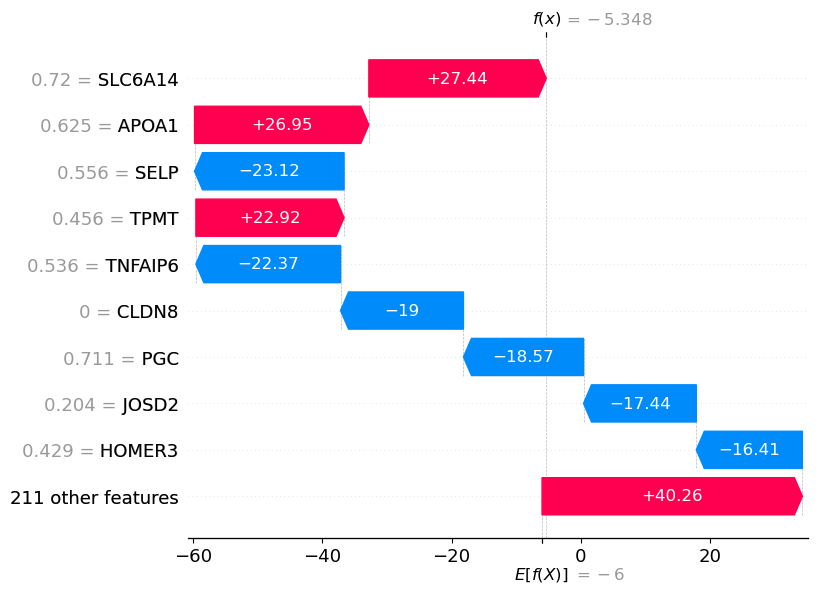

In [30]:
shap.waterfall_plot(explanation)
# shap.waterfall_plot(gene_shap.Explanation(values=shap_values[2][idx], 
#                                               base_values=explainer.expected_value[2], data=x_test_scaled.iloc[idx],  
#                                          feature_names=x_test_scaled.columns.tolist()))

## Dependent - 41

In [6]:
idx = 41

In [23]:
# autoencoder
explainer = objects.get_explainer(model=gmm_model_get_prediction_ae, data=x_train_scaled, link="logit", feature_dependence=True, specific_indices=[idx])
# PCA
# explainer = objects.get_explainer(model=gmm_model_get_prediction_pca, data=x_train_scaled, link="logit")

getting explainerinitialising explainer
link.f
link.f
link.f
link.f


In [8]:
# with open("shap_values", "wb") as fp:   #Pickling
#     pickle.dump(shap_values, fp)

In [9]:

with open("../data/models/shap/new_fd_41_1samp_2p9", "rb") as fp:   # Unpickling
    shap_values = pickle.load(fp)

In [10]:
# shap_values[0][0].shape

In [11]:
shap_values = shap_values[0]

In [12]:
# shap_values[0] *= 100000

In [13]:
shap_values

[array([[  1.2195951 ,   1.00112774,   1.70654422,   0.        ,
          -2.1376458 ,   0.        ,   0.        ,  -7.45812308,
           1.61473182,   0.        ,  -4.67287771,   4.09299606,
           9.06935291,  -0.65412777,  -9.22694384,   0.        ,
          -0.23213976,   6.31322131,   2.91323662,  -1.11030862,
          -4.19241033,  -2.82713215,  -3.92844496,   0.        ,
          -0.15047409,   0.        ,  -0.10407171,   1.26612235,
           2.53048605,  -1.74715652,   2.95287941,   0.        ,
          -0.01626672,   4.86735992,  -2.13149688,  -2.08502175,
           3.18654814,  -3.3282942 ,   0.88966038,   3.90996078,
          -4.26921513,   3.89625771,   0.79500544,  -2.90646065,
           2.03793364,  -0.20679405,   0.        ,  -1.95945213,
           0.        ,   2.6180251 ,   5.52479705,   2.55228013,
           2.92077089,  -0.48859451,  -8.19289058,  -3.94435591,
          -4.59525914,  -2.23911432,   2.50648571,   5.79921709,
          -5.48577065,   

In [14]:
print(f'length of SHAP values: {len(shap_values)}')
print(f'Shape of each element: {shap_values[0].shape}')

length of SHAP values: 3
Shape of each element: (1, 220)


Target Classes:
0: control
1: CD no ulcer
2: CD deep ulcer

In [15]:
idx = 41
patient = x_test_scaled.iloc[[idx],:]
patient

AADAC     APOA1     APOA4      APOB     APOC3      AQP9  \
Patient_ID                                                                      
260_CD_deep_ulcer  0.588189  0.625309  0.750597  0.746795  0.678619  0.578012   

                         C6   CEACAM7    CHI3L1     ABCC2  ...    HDLBP  \
Patient_ID                                                 ...            
260_CD_deep_ulcer  0.191236  0.321755  0.595506  0.569387  ...  0.73261   

                      PIAS4     ADH1B  LOC100507531    FAM83A  NXF4    RNF125  \
Patient_ID                                                                      
260_CD_deep_ulcer  0.822309  0.569633           0.0  0.590696   0.0  0.341364   

                       DARS  DNAI1    MBTPS1  
Patient_ID                                    
260_CD_deep_ulcer  0.322348    0.0  0.664423  

[1 rows x 220 columns]

In [16]:
print(f'Prediction probabilities for patient: {gmm_model_get_prediction_ae(patient)[0]}')
print("Predicted class:",np.argmax(gmm_model_get_prediction_ae(patient)[0]))

Prediction probabilities for patient: [2.25685074e-14 8.20535540e-01 1.79464460e-01]
Predicted class: 1


#### Control

In [17]:
import shap

In [18]:

shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][0], patient, link="logit")

####  CD no ulcer

In [19]:

shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][0], patient, link="logit")

####  CD deep ulcer

In [20]:

shap.initjs()
shap.force_plot(explainer.expected_value[2], shap_values[2][0], patient, link="logit")

In [24]:
# gene_shap.plots.bar(Explanation(x_test_scaled)[0], clustering=clustering)
idx = 41
explanation = objects.get_explanation(values=shap_values[2][0], 
                                              base_values=explainer.expected_value[2], data=x_test_scaled.iloc[idx],  
                                         feature_names=x_test_scaled.columns.tolist())

type(explanation)

getting explanation


_explanation.Explanation

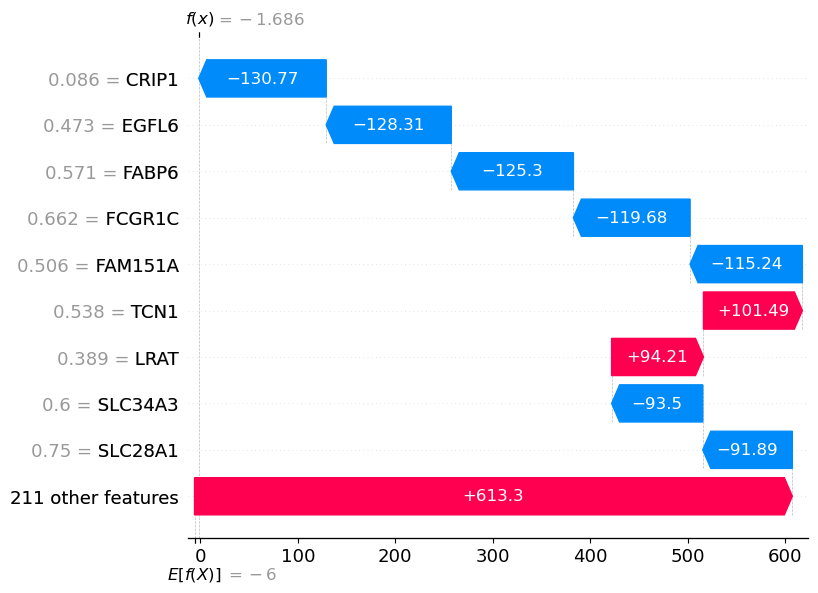

In [25]:
shap.waterfall_plot(explanation)
# shap.waterfall_plot(gene_shap.Explanation(values=shap_values[2][idx], 
#                                               base_values=explainer.expected_value[2], data=x_test_scaled.iloc[idx],  
#                                          feature_names=x_test_scaled.columns.tolist()))

## Dependent - 18

In [48]:
idx = 18

In [49]:
# autoencoder
explainer = objects.get_explainer(model=gmm_model_get_prediction_ae, data=x_test_scaled, link="logit", feature_dependence=True, specific_indices=[idx])
# PCA
# explainer = objects.get_explainer(model=gmm_model_get_prediction_pca, data=x_train_scaled, link="logit")

getting explainerinitialising explainer
link.f
link.f
link.f
link.f


In [50]:
# with open("shap_values", "wb") as fp:   #Pickling
#     pickle.dump(shap_values, fp)

In [51]:

with open("../data/models/shap/new_fd_18_M", "rb") as fp:   # Unpickling
    shap_values = pickle.load(fp)

In [52]:
# shap_values[0][0].shape

In [53]:
shap_values = shap_values[0]

In [54]:
# shap_values[0] *= 100000

In [55]:
shap_values

[array([[ -20.80592883,  -20.27727609,  -22.95664758,   -4.6541394 ,
           24.87024289,   -6.30978925,  -21.4169204 ,   71.18635377,
          -23.06617082,  -53.12390035,  -21.88759955,   -1.83153717,
          -19.76636498,  104.10322782,  -81.62459243,  -10.45753758,
           39.5859843 ,  -12.84962465,  -34.78249727, -122.3316667 ,
            2.98881764,  146.6956194 ,  -48.3763691 ,   73.94122743,
           -9.46628563,   15.01135891,  -21.81993484,  -78.5073959 ,
           85.13305602,   46.07323622,   29.64549286,  -18.03562365,
           30.43649501,  -75.17038684,  -67.67196798,   68.35712066,
          -39.58906821,   11.17080116,  -62.36634101,  -57.16934857,
           16.64406972,   89.54755674,  -41.69613634,   -4.1269528 ,
           47.11359953,   80.65169987,   48.48211182,  -22.97251651,
           17.02206819,  -76.33066124,   20.81151039,    0.        ,
           60.89413191,  -22.69287449, -128.01768475,    0.        ,
           54.4783137 ,   10.68853

In [56]:
print(f'length of SHAP values: {len(shap_values)}')
print(f'Shape of each element: {shap_values[0].shape}')

length of SHAP values: 3
Shape of each element: (1, 220)


Target Classes:
0: control
1: CD no ulcer
2: CD deep ulcer

In [57]:
idx = 18
patient = x_test_scaled.iloc[[idx],:]
patient

AADAC     APOA1     APOA4      APOB     APOC3      AQP9  \
Patient_ID                                                                     
46_CD_deep_ulcer  0.438089  0.482152  0.410237  0.378247  0.438691  0.705762   

                        C6   CEACAM7    CHI3L1     ABCC2  ...     HDLBP  \
Patient_ID                                                ...             
46_CD_deep_ulcer  0.339106  0.559666  0.878088  0.228893  ...  0.964177   

                     PIAS4     ADH1B  LOC100507531    FAM83A  NXF4    RNF125  \
Patient_ID                                                                     
46_CD_deep_ulcer  0.715558  0.716592           0.0  0.684122   0.0  0.136883   

                      DARS  DNAI1    MBTPS1  
Patient_ID                                   
46_CD_deep_ulcer  0.624877    0.0  0.877226  

[1 rows x 220 columns]

In [58]:
print(f'Prediction probabilities for patient: {gmm_model_get_prediction_ae(patient)[0]}')
print("Predicted class:",np.argmax(gmm_model_get_prediction_ae(patient)[0]))

Prediction probabilities for patient: [6.47976206e-51 1.38192942e-03 9.98618071e-01]
Predicted class: 2


#### Control

In [59]:
import shap

In [60]:

shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][0], patient, link="logit")

####  CD no ulcer

In [61]:

shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][0], patient, link="logit")

####  CD deep ulcer

In [62]:

shap.initjs()
shap.force_plot(explainer.expected_value[2], shap_values[2][0], patient, link="logit")

In [63]:
# deep ulcer
idx = 18
explanation = objects.get_explanation(values=shap_values[2][0], 
                                              base_values=explainer.expected_value[2], data=x_test_scaled.iloc[idx],  
                                         feature_names=x_test_scaled.columns.tolist())

type(explanation)

getting explanation


_explanation.Explanation

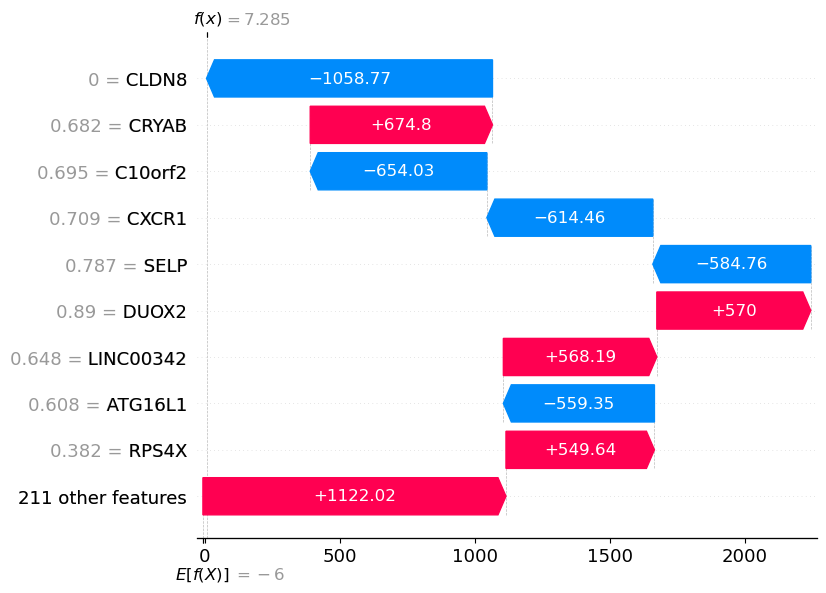

In [64]:
shap.waterfall_plot(explanation)
# shap.waterfall_plot(gene_shap.Explanation(values=shap_values[2][idx], 
#                                               base_values=explainer.expected_value[2], data=x_test_scaled.iloc[idx],  
#                                          feature_names=x_test_scaled.columns.tolist()))

## Independent - 18

In [65]:
idx = 18

In [66]:
explainer = objects.get_explainer(model=gmm_model_get_prediction_ae, data=x_test_scaled, link="logit", feature_dependence=False, specific_indices=[18])

getting explainerinitialising explainer
link.f
link.f
link.f
link.f


In [67]:


with open("../data/models/shap/new_ind_18_M", "rb") as fp:   # Unpickling
    shap_values = pickle.load(fp)

In [68]:
shap_values = shap_values[0]

In [69]:
shap_values

[array([[  -8.49523079,  -18.36202089,  -23.57093866,    7.12658249,
          -28.79938993,   59.59749326,  -18.55138025,   55.76552906,
          -20.95125103,  -40.4129419 ,  -21.40030536,  -20.0035038 ,
          -19.35460052,  101.26933897,  -69.69807613,  -20.13567215,
           45.08505934,  -21.01009726,  -17.05120551,  -73.7835716 ,
           -7.2883914 ,  104.84741964,  -13.45222238,   57.65586939,
          -20.73441135,   34.38405372,  -23.63108974,  -33.95270138,
           61.72684075,   71.29336538,   42.423175  ,  -23.43423809,
           22.28923691, -105.45799573,  -42.87553303,   52.96408673,
          -64.60945629,  -12.5909884 ,  -80.97309469,  -52.32299515,
           13.00673986,   65.13931044, -103.045495  ,   17.10204735,
          -34.19657987,   64.0750104 ,   50.2482315 ,  -21.62507094,
          -10.19916094,  -80.26992742,   33.35731302,   10.65641014,
           94.13366159,  -22.44434099,  -19.49745596,   -5.72930694,
           77.5835223 ,    0.     

In [70]:
print(f'length of SHAP values: {len(shap_values)}')
print(f'Shape of each element: {shap_values[0].shape}')

length of SHAP values: 3
Shape of each element: (1, 220)


In [71]:
idx = 18
patient = x_test_scaled.iloc[[idx],:]
patient

AADAC     APOA1     APOA4      APOB     APOC3      AQP9  \
Patient_ID                                                                     
46_CD_deep_ulcer  0.438089  0.482152  0.410237  0.378247  0.438691  0.705762   

                        C6   CEACAM7    CHI3L1     ABCC2  ...     HDLBP  \
Patient_ID                                                ...             
46_CD_deep_ulcer  0.339106  0.559666  0.878088  0.228893  ...  0.964177   

                     PIAS4     ADH1B  LOC100507531    FAM83A  NXF4    RNF125  \
Patient_ID                                                                     
46_CD_deep_ulcer  0.715558  0.716592           0.0  0.684122   0.0  0.136883   

                      DARS  DNAI1    MBTPS1  
Patient_ID                                   
46_CD_deep_ulcer  0.624877    0.0  0.877226  

[1 rows x 220 columns]

In [72]:
print(f'Prediction probabilities for patient: {gmm_model_get_prediction_ae(patient)[0]}')
print("Predicted class:", np.argmax(gmm_model_get_prediction_ae(patient)[0]))

Prediction probabilities for patient: [6.47976206e-51 1.38192942e-03 9.98618071e-01]
Predicted class: 2


#### Control

In [73]:
import shap

In [74]:

shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][0], patient, link="logit")

####  CD no ulcer

In [75]:

shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][0], patient, link="logit")

####  CD deep ulcer

In [76]:

shap.initjs()
shap.force_plot(explainer.expected_value[2], shap_values[2][0], patient, link="logit")

In [77]:
# gene_shap.plots.bar(Explanation(x_test_scaled)[0], clustering=clustering)
#deep ulcer
idx = 18
explanation = objects.get_explanation(values=shap_values[2][0], 
                                              base_values=explainer.expected_value[2], data=x_test_scaled.iloc[idx],  
                                         feature_names=x_test_scaled.columns.tolist())

type(explanation)

getting explanation


_explanation.Explanation

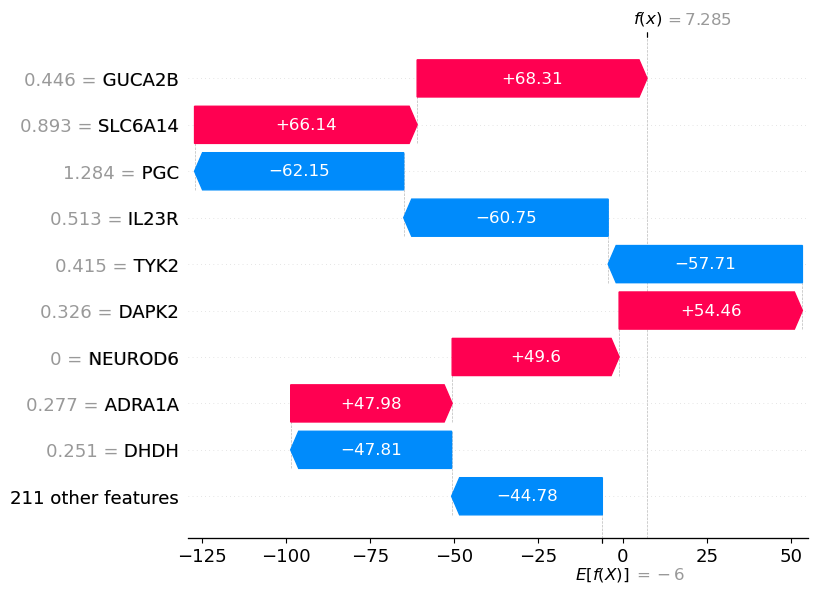

In [78]:
shap.waterfall_plot(explanation)
# shap.waterfall_plot(gene_shap.Explanation(values=shap_values[2][idx], 
#                                               base_values=explainer.expected_value[2], data=x_test_scaled.iloc[idx],  
#                                          feature_names=x_test_scaled.columns.tolist()))

In [79]:
# control
explanation = objects.get_explanation(values=shap_values[0][0], 
                                              base_values=explainer.expected_value[0], data=x_test_scaled.iloc[idx],  
                                         feature_names=x_test_scaled.columns.tolist())

getting explanation


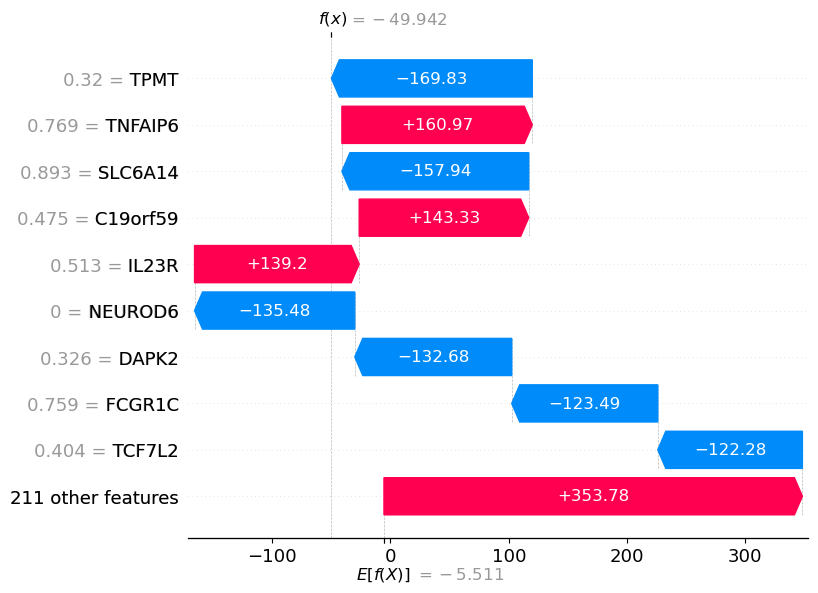

In [80]:
shap.waterfall_plot(explanation)

## Independent - 77

In [81]:
idx = 77

In [82]:
# autoencoder
explainer = objects.get_explainer(model=gmm_model_get_prediction_ae, data=x_test_scaled, link="logit", feature_dependence=False, specific_indices=[idx])
# PCA
# explainer = objects.get_explainer(model=gmm_model_get_prediction_pca, data=x_train_scaled, link="logit")

getting explainerinitialising explainer
link.f
link.f
link.f
link.f


In [83]:


with open("../data/models/shap/new_ind_77_400", "rb") as fp:   # Unpickling
    shap_values = pickle.load(fp)

In [84]:
shap_values = shap_values[0]

In [85]:
shap_values

[array([[  0.        ,  -0.36534849,  -8.05831297,  -5.78204161,
          -2.83889054,  10.18765614,   8.16306332,   0.        ,
           0.37929306,  -1.53386164,   0.        ,  -0.18952567,
          -1.08030822,   0.        ,  10.45792507,   0.        ,
           4.55011796,  -7.07985177,   0.        ,  -1.42523469,
           0.39187351,  -3.53300481,   2.46473123,   9.78967574,
          -3.7961999 ,  -2.2986408 ,  -4.1697161 ,   5.03034257,
           1.50015878,   1.20455587,   0.7405645 ,  -3.58496785,
           8.61096339,   4.95342083,  -2.9700925 ,  -2.13637972,
          -4.27223639,  -8.7042977 ,   1.36137362,  -3.55724894,
          -2.63506687,  -2.58028254,   5.13276932,  -4.10452095,
           0.        ,   0.06187612,   0.        ,   9.1735685 ,
          -9.56984418,   3.93527182,   8.97275681,  -3.26001007,
          -7.79792517,  -4.25366418,   6.64492012,   0.        ,
          -8.01021575,   0.        ,  -1.76094136,  -4.01021164,
          -3.67649766,  -

In [86]:
print(f'length of SHAP values: {len(shap_values)}')
print(f'Shape of each element: {shap_values[0].shape}')

length of SHAP values: 3
Shape of each element: (1, 220)


In [87]:
idx = 77
patient = x_test_scaled.iloc[[idx],:]
patient

AADAC     APOA1    APOA4      APOB    APOC3      AQP9  \
Patient_ID                                                                    
256_CD_deep_ulcer  0.609459  0.598912  0.68205  0.765806  0.64835  0.450384   

                    C6   CEACAM7   CHI3L1     ABCC2  ...     HDLBP     PIAS4  \
Patient_ID                                           ...                       
256_CD_deep_ulcer  0.0  0.377102  0.44438  0.667302  ...  0.710513  0.667492   

                      ADH1B  LOC100507531    FAM83A  NXF4    RNF125      DARS  \
Patient_ID                                                                      
256_CD_deep_ulcer  0.601592           0.0  0.653043   0.0  0.409098  0.449809   

                      DNAI1    MBTPS1  
Patient_ID                             
256_CD_deep_ulcer  0.152556  0.599646  

[1 rows x 220 columns]

In [88]:
print(f'Prediction probabilities for patient: {gmm_model_get_prediction_ae(patient)[0]}')
print("Predicted class:",np.argmax(gmm_model_get_prediction_ae(patient)[0]))

Prediction probabilities for patient: [2.85473038e-10 9.88979666e-01 1.10203337e-02]
Predicted class: 1


#### Control

In [89]:
import shap

In [90]:

shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][0], patient, link="logit")

####  CD no ulcer

In [91]:

shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][0], patient, link="logit")

####  CD deep ulcer

In [92]:

shap.initjs()
shap.force_plot(explainer.expected_value[2], shap_values[2][0], patient, link="logit")

In [93]:
# gene_shap.plots.bar(Explanation(x_test_scaled)[0], clustering=clustering)
idx = 77
explanation = objects.get_explanation(values=shap_values[2][0], 
                                              base_values=explainer.expected_value[2], data=x_test_scaled.iloc[idx],  
                                         feature_names=x_test_scaled.columns.tolist())

type(explanation)

getting explanation


_explanation.Explanation

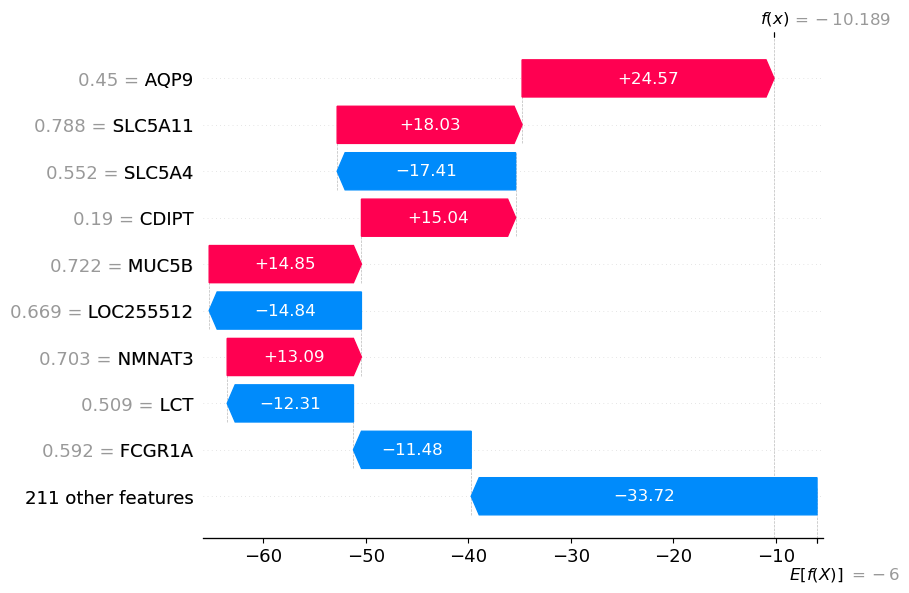

In [94]:
shap.waterfall_plot(explanation)
# shap.waterfall_plot(gene_shap.Explanation(values=shap_values[2][idx], 
#                                               base_values=explainer.expected_value[2], data=x_test_scaled.iloc[idx],  
#                                          feature_names=x_test_scaled.columns.tolist()))

## Dependent - 77

In [95]:
idx = 77

In [96]:
# autoencoder
explainer = objects.get_explainer(model=gmm_model_get_prediction_ae, data=x_test_scaled, link="logit", feature_dependence=True, specific_indices=[idx])
# PCA
# explainer = objects.get_explainer(model=gmm_model_get_prediction_pca, data=x_train_scaled, link="logit")

getting explainerinitialising explainer
link.f
link.f
link.f
link.f


In [97]:
# with open("shap_values", "wb") as fp:   #Pickling
#     pickle.dump(shap_values, fp)

In [98]:

with open("../data/models/shap/new_fd_77_1samp", "rb") as fp:   # Unpickling
    shap_values = pickle.load(fp)

In [99]:
# shap_values[0][0].shape

In [100]:
shap_values = shap_values[0]

In [101]:
# shap_values[0] *= 100000

In [102]:
shap_values

[array([[-6.09138183e+00,  2.43421649e+01, -1.73891729e+00,
         -8.39213419e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  3.48147083e+01, -2.62181178e+01,
          1.43587867e+01,  1.77602235e+01,  6.08008151e+00,
         -2.12357106e+01,  1.10427341e+01,  2.11777443e+01,
         -6.35118520e+00, -9.57117687e+00, -5.32107259e+00,
          0.00000000e+00, -2.62620946e+01, -5.04559586e+00,
          0.00000000e+00, -1.94293475e+00,  1.87976865e+01,
          2.50274878e+01,  0.00000000e+00, -1.74831368e+00,
          1.86553241e+01, -1.88617096e+01, -4.18674115e+01,
         -1.18085815e+00, -4.33466102e+00, -2.54123685e+00,
          1.60553997e+01, -5.70548152e+00, -2.55241469e+01,
         -1.04563458e+00, -4.59899842e+01, -1.18826420e+00,
         -1.22322636e+01, -6.56179419e-02, -2.21442266e+01,
         -1.61104818e+01, -2.20574213e+00,  1.52406432e+01,
          4.74589998e+00,  7.57440958e+00,  1.16217655e+01,
         -7.08929374e+00, -5.02751974e+0

In [103]:
print(f'length of SHAP values: {len(shap_values)}')
print(f'Shape of each element: {shap_values[0].shape}')

length of SHAP values: 3
Shape of each element: (1, 220)


Target Classes:
0: control
1: CD no ulcer
2: CD deep ulcer

In [104]:
idx = 77
patient = x_test_scaled.iloc[[idx],:]
patient

AADAC     APOA1    APOA4      APOB    APOC3      AQP9  \
Patient_ID                                                                    
256_CD_deep_ulcer  0.609459  0.598912  0.68205  0.765806  0.64835  0.450384   

                    C6   CEACAM7   CHI3L1     ABCC2  ...     HDLBP     PIAS4  \
Patient_ID                                           ...                       
256_CD_deep_ulcer  0.0  0.377102  0.44438  0.667302  ...  0.710513  0.667492   

                      ADH1B  LOC100507531    FAM83A  NXF4    RNF125      DARS  \
Patient_ID                                                                      
256_CD_deep_ulcer  0.601592           0.0  0.653043   0.0  0.409098  0.449809   

                      DNAI1    MBTPS1  
Patient_ID                             
256_CD_deep_ulcer  0.152556  0.599646  

[1 rows x 220 columns]

In [105]:
print(f'Prediction probabilities for patient: {gmm_model_get_prediction_ae(patient)[0]}')
print("Predicted class:",np.argmax(gmm_model_get_prediction_ae(patient)[0]))

Prediction probabilities for patient: [2.85473038e-10 9.88979666e-01 1.10203337e-02]
Predicted class: 1


#### Control

In [106]:
import shap

In [107]:

shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][0], patient, link="logit")

####  CD no ulcer

In [108]:

shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][0], patient, link="logit")

####  CD deep ulcer

In [109]:

shap.initjs()
shap.force_plot(explainer.expected_value[2], shap_values[2][0], patient, link="logit")

In [110]:
# gene_shap.plots.bar(Explanation(x_test_scaled)[0], clustering=clustering)
idx = 77
explanation = objects.get_explanation(values=shap_values[2][0], 
                                              base_values=explainer.expected_value[2], data=x_test_scaled.iloc[idx],  
                                         feature_names=x_test_scaled.columns.tolist())

type(explanation)

getting explanation


_explanation.Explanation

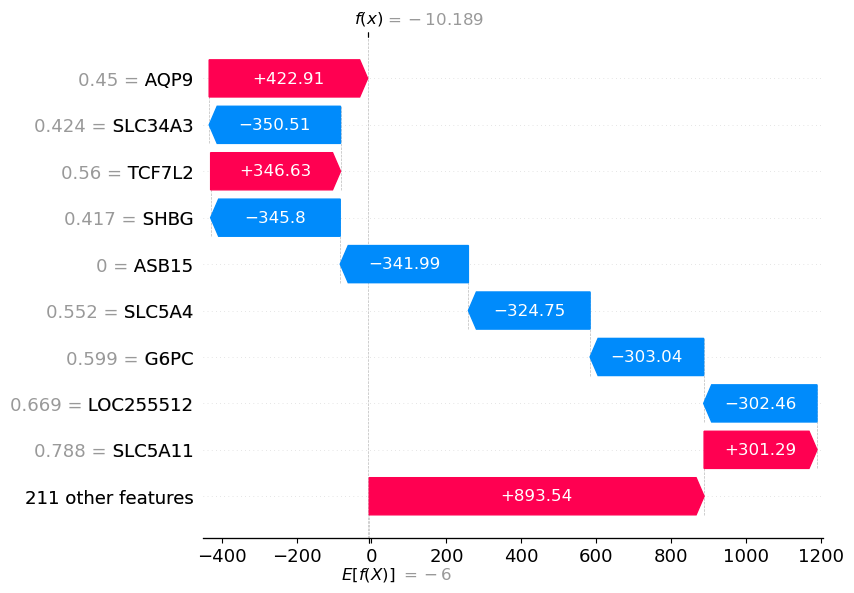

In [111]:
shap.waterfall_plot(explanation)
# shap.waterfall_plot(gene_shap.Explanation(values=shap_values[2][idx], 
#                                               base_values=explainer.expected_value[2], data=x_test_scaled.iloc[idx],  
#                                          feature_names=x_test_scaled.columns.tolist()))